In [7]:
# import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
# import geopy.distance
import xarray as xr
import pandas as pd
# import rasterio
# import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import random
import glob
4

import warnings
warnings.filterwarnings('ignore')

In [8]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
dirHadisd = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Data-edcoffel-F20/hadisd'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'

land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1

In [10]:
x = xr.open_dataset(f'{dirHadisd}/station_correlations_with_latlon.nc')

In [11]:
import xarray as xr
import numpy as np
import statsmodels.api as sm

# Prepare arrays to store the trends and mean correlations
trends = []
mean_correlations = []

# Define the criteria for blocks
min_total_years = (2021-1981+1)  # Minimum total valid years required
min_block_years = 1   # Minimum consecutive years in each block

# Define the year range for filtering
start_year = 1981
end_year = 2021

# Loop through each station to calculate the linear trend and mean correlation
for station_index in range(len(x.station)):
    station_id = x.station.values[station_index]
    correlations = x['correlations'].isel(station=station_index)

    # Drop missing data and extract the year indices
    correlations_clean = correlations.dropna(dim='year')
    correlations_clean = correlations_clean.sel(year=slice(start_year, end_year))  # Filter by year range
    available_years = correlations_clean.year.values

    # Skip stations with no valid data
    if len(available_years) == 0:
        trends.append(np.nan)
        mean_correlations.append(np.nan)
        continue

    # Identify consecutive blocks of years
    year_diff = np.diff(available_years)
    breaks = np.where(year_diff > 1)[0]  # Find where the gaps are
    blocks = np.split(available_years, breaks + 1)  # Split into blocks of consecutive years

    # Filter blocks to ensure each block has at least the minimum block years
    valid_blocks = [block for block in blocks if len(block) >= min_block_years]

    # Ensure the total valid years meet the minimum requirement
    total_valid_years = sum(len(block) for block in valid_blocks)
    if total_valid_years < min_total_years:
        trends.append(np.nan)
        mean_correlations.append(np.nan)
        continue

    # Combine all valid blocks for the calculations
    valid_years = np.concatenate(valid_blocks)
    block_correlations = correlations_clean.sel(year=valid_years)

    # Extract years and correlation values for regression
    years = block_correlations.year.values
    correlation_values = block_correlations.values

    # Calculate the mean correlation for the valid data
    mean_correlation = np.nanmean(correlation_values)
    mean_correlations.append(mean_correlation)

    # Add a constant term for the intercept in regression
    nn = np.where(~np.isnan(correlation_values))[0]
    X = sm.add_constant(years[nn])
    y = correlation_values[nn]

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Append the slope (trend) to the trends array
    trends.append(model.params[1])  # The slope of the linear trend

# Add trends and mean correlations as new variables in the dataset
x['correlation_trend'] = (('station',), trends)
x['mean_correlation'] = (('station',), mean_correlations)

print("Linear trends and mean correlations calculated for years 1981-2021 and saved.")


Linear trends and mean correlations calculated for years 1981-2021 and saved.


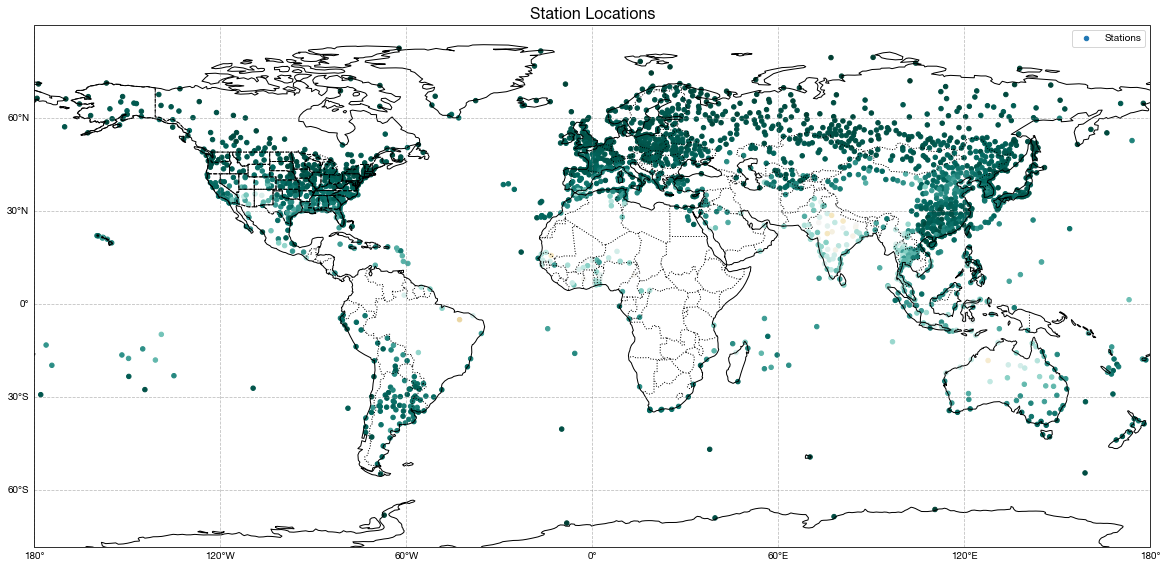

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Open the NetCDF dataset
# x = xr.open_dataset(f'{dirHadisd}/station_correlations_with_latlon.nc')

# Extract station latitude and longitude
lats = x['station_latitude'].values
lons = x['station_longitude'].values
station_ids = x['station_id'].values

# Initialize the map with Cartopy
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--')

# Scatter plot of stations
plt.scatter(lons, lats, c=x['mean_correlation'].values, s=20, transform=ccrs.PlateCarree(), label='Stations', cmap='BrBG', vmin=-1, vmax=1)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gl.top_labels = False  # Turn off top labels
gl.right_labels = False  # Turn off right labels

# Add title and legend
plt.title('Station Locations', fontsize=16)
plt.legend()

# Show the map
plt.show()


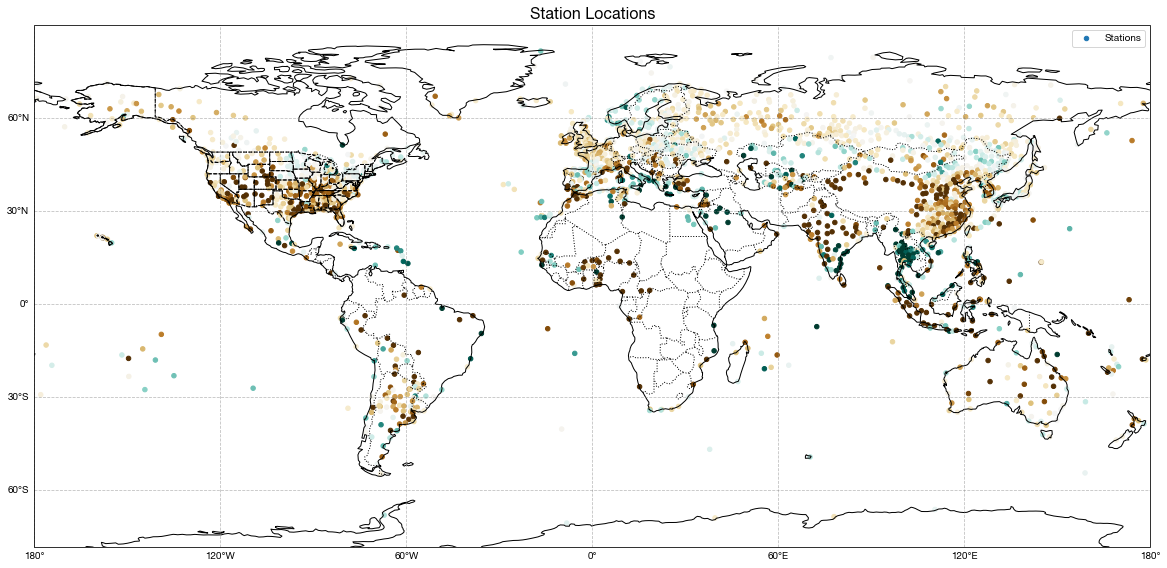

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Open the NetCDF dataset
# x = xr.open_dataset(f'{dirHadisd}/station_correlations_with_latlon.nc')

# Extract station latitude and longitude
lats = x['station_latitude'].values
lons = x['station_longitude'].values
station_ids = x['station_id'].values

# Initialize the map with Cartopy
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--')

# Scatter plot of stations
plt.scatter(lons, lats, c=x['correlation_trend'].values, s=20, transform=ccrs.PlateCarree(), label='Stations', cmap='BrBG', vmin=-.003, vmax=.003)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gl.top_labels = False  # Turn off top labels
gl.right_labels = False  # Turn off right labels

# Add title and legend
plt.title('Station Locations', fontsize=16)
plt.legend()

# Show the map
plt.show()


In [14]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_tw_corr_full = xr.open_mfdataset('output/tx_tw_corr/tx_tw_corr_warm_season_*.nc', preprocess = add_time_dim, combine='nested', concat_dim='time')
tx_tw_corr_full['time'] = time_dim
tx_tw_corr_full = tx_tw_corr_full.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
tx_tw_corr_full = tx_tw_corr_full.where(land_sea_mask_binary)

tx_tw_corr_full = tx_tw_corr_full.sel(latitude=slice(60,-60))
tx_tw_corr_full.load()
tx_tw_corr_mean = tx_tw_corr_full.mean(dim='time')


tx_tw_corr_trend = xr.open_dataset('era5_tx_tw_corr_warm_season_trend.nc')
tx_tw_corr_trend.load()
tx_tw_corr_trend = tx_tw_corr_trend.sel(latitude=slice(60,-60))


In [15]:
import numpy as np

# Station latitudes and longitudes
station_lats = x['station_latitude'].values
station_lons = x['station_longitude'].values

# Convert station longitudes from [-180, 180] to [0, 360]
station_lons_360 = (station_lons + 360) % 360

# Get the grid latitudes and longitudes
grid_lats = tx_tw_corr_mean.latitude.values
grid_lons = tx_tw_corr_mean.longitude.values

# Initialize lists to store the closest grid cell indices
closest_lat_indices = []
closest_lon_indices = []

# Loop through each station to find the closest grid cell
for lat, lon in zip(station_lats, station_lons_360):
    # Calculate the absolute difference between the station's lat/lon and all grid lat/lons
    lat_diffs = np.abs(grid_lats - lat)
    lon_diffs = np.abs(grid_lons - lon)
    
    # Find the index of the closest latitude and longitude
    closest_lat_idx = np.argmin(lat_diffs)
    closest_lon_idx = np.argmin(lon_diffs)
    
    # Store the indices
    closest_lat_indices.append(closest_lat_idx)
    closest_lon_indices.append(closest_lon_idx)

# Combine the results into a structured array or dataset for easier access
closest_cells = {
    'station_lat': station_lats,
    'station_lon': station_lons,
    'grid_lat_idx': closest_lat_indices,
    'grid_lon_idx': closest_lon_indices,
    'grid_lat': grid_lats[closest_lat_indices],
    'grid_lon': grid_lons[closest_lon_indices]
}


In [16]:
# Step 1: Extract mean_correlation from station data
mean_correlation = x['mean_correlation'].values  # Assuming this is in the station dataset
corr_trend = x['correlation_trend'].values  # Assuming this is in the station dataset

# Step 2: Extract corresponding data values from the grid dataset
# Initialize a list to store the grid values
grid_values = []
grid_trends = []

# Loop through each closest grid cell
for lat_idx, lon_idx in zip(closest_lat_indices, closest_lon_indices):
    grid_value = tx_tw_corr_mean.tx_tw_corr.isel(latitude=lat_idx, longitude=lon_idx).values
    grid_values.append(grid_value)
    
    grid_trend = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.isel(latitude=lat_idx, longitude=lon_idx).values
    grid_trends.append(grid_trend)

# Step 3: Combine mean_correlation and grid values for comparison
comparison_data = {
    'station_lat': station_lats,
    'station_lon': station_lons,
    'mean_correlation': mean_correlation,
    'corr_trend':corr_trend,
    'grid_lat': grid_lats[closest_lat_indices],
    'grid_lon': grid_lons[closest_lon_indices],
    'grid_mean': grid_values,
    'grid_trends': grid_trends,
    
}

# Create a DataFrame for comparison
df_comparison = pd.DataFrame(comparison_data)

# Step 4: Drop rows where mean_correlation is NaN
df_comparison = df_comparison.dropna(subset=['mean_correlation'])

# Step 5: Filter stations between 60°S and 60°N
df_comparison = df_comparison[(df_comparison['station_lat'] >= -60) & (df_comparison['station_lat'] <= 60)]


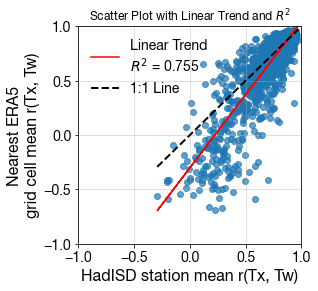

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Extract the x (mean_correlation) and y (grid_value) values
x = df_comparison['mean_correlation'].values
y = np.array([float(item) if not np.isnan(item) else np.nan for item in df_comparison['grid_mean'].values])

nn = np.where(~np.isnan(x) & ~np.isnan(y))

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x[nn], y[nn])
line = slope * x[nn] + intercept  # Line equation

# Scatter plot
plt.figure(figsize=(4, 4))
plt.ylim([-1,1])
plt.xlim([-1,1])
plt.scatter(x, y, alpha=0.7)

# Plot the linear trend line
plt.plot(x[nn], line, color='red', label=f'Linear Trend\n$R^2$ = {r_value**2:.3f}')
plt.plot([min(x), max(x)], [min(x), max(x)], color='k', linestyle='--', lw=2,label='1:1 Line')


# Add labels, legend, and title
plt.xlabel('HadISD station mean r(Tx, Tw)')
plt.ylabel('Nearest ERA5\ngrid cell mean r(Tx, Tw)')
plt.title('Scatter Plot with Linear Trend and $R^2$')
plt.legend(fontsize=14, frameon=False)
plt.grid(alpha=0.5)

# Show the plot
plt.show()


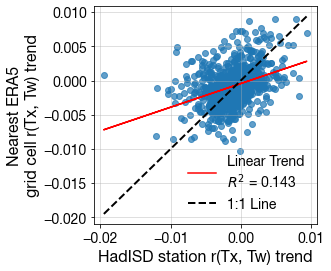

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Extract the x (mean_correlation) and y (grid_value) values
x = df_comparison['corr_trend'].values
y = np.array([float(item) if not np.isnan(item) else np.nan for item in df_comparison['grid_trends'].values])

nn = np.where(~np.isnan(x) & ~np.isnan(y))

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x[nn], y[nn])
line = slope * x[nn] + intercept  # Line equation

# Scatter plot
plt.figure(figsize=(4, 4))
plt.scatter(x, y, alpha=0.7)

# Plot the linear trend line
plt.plot(x[nn], line, color='red', label=f'Linear Trend\n$R^2$ = {r_value**2:.3f}')
plt.plot([min(x), max(x)], [min(x), max(x)], color='k', linestyle='--', lw=2,label='1:1 Line')


# Add labels, legend, and title
plt.xlabel('HadISD station r(Tx, Tw) trend')
plt.ylabel('Nearest ERA5\ngrid cell r(Tx, Tw) trend')
plt.legend(fontsize=14, frameon=False)
plt.grid(alpha=0.5)

# Show the plot
plt.show()


In [194]:
nn.size

1955